In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [39]:
df = pd.read_feather('../data/back_test_output_valid.feather')
df_btc = df.loc[df['token'] == 0].reset_index(drop = True)

In [5]:
def get_proportion(df):
    class_0_pred = (df['pred_label'] == 0).sum() / df.shape[0]
    class_1_pred = (df['pred_label'] == 1).sum() / df.shape[0]
    class_2_pred = (df['pred_label'] == 2).sum() / df.shape[0]
    sum0 = (df['label'] == 0).sum()
    sum1 = (df['label'] == 1).sum()
    sum2 = (df['label'] == 2).sum()
    class_0 = (df['label'] == 0).sum() / df.shape[0]
    class_1 = (df['label'] == 1).sum() / df.shape[0]
    class_2 = (df['label'] == 2).sum() / df.shape[0]
    print(f'Class 0 Pred: {class_0_pred}; Class 0 True: {class_0}')
    print(f'Class 1 Pred: {class_1_pred}; Class 1 True: {class_1}')
    print(f'Class 2 Pred: {class_2_pred}; Class 1 True: {class_2}')
    return

In [6]:
get_proportion(df)

Class 0 Pred: 0.4606794294294294; Class 0 True: 0.7189617827286746
Class 1 Pred: 0.22486379961042124; Class 1 True: 0.138683446960474
Class 2 Pred: 0.31445677096014935; Class 1 True: 0.1423547703108514


In [7]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(df_btc['label'], df_btc['pred_label'], )
confusion_mat

array([[155127,  59369,  86303],
       [ 12839,  14144,  19092],
       [ 12858,  14283,  20257]])

Create back test running 15 different strategies
- strat 1: 9:00 - 9:15
- strat 2: 9:01 - 9:16 etc

In [52]:
sample_df = pd.DataFrame(
    {'open_time' : ['2022-08-16 07:20:00', '2022-08-16 07:21:00', '2022-08-16 07:22:00',
                    '2022-08-16 07:23:00', '2022-08-16 07:24:00', '2022-08-16 07:25:00',
                    '2022-08-16 07:26:00', '2022-08-16 07:27:00', '2022-08-16 07:28:00'],
     'pred_label' : [1, 1, 1,
                     2, 1, 1,
                     2, 0, 0],
     'close_t+1' : [1875.9, 1877.79, 1878.55,
                    1878.46, 1878.44, 1878.70,
                    1879.87, 1879.40, 1878.15],
     'close_t+16' : [1878.30, 1878.90, 1877.51,
                     1879.44, 1880.38, 1880.11,
                     1881.25, 1880.18, 1881.85]}
)



In [45]:
sample_df

,open_time,pred_label,close_t+1,close_t+16,NV,pnl
0,2022-08-16 07:20:00,1,1875.90,1878.30,9987.206141,-12.793859
1,2022-08-16 07:21:00,1,1877.79,1878.90,9981.302500,-5.903641
2,2022-08-16 07:22:00,1,1878.55,1877.51,9986.828333,5.525834
3,2022-08-16 07:23:00,2,1878.46,1879.44,9992.038501,0.000000
4,2022-08-16 07:24:00,1,1878.44,1880.38,9981.719005,-10.319496
5,2022-08-16 07:25:00,1,1878.70,1880.11,9974.227535,-7.491470
6,2022-08-16 07:26:00,2,1879.87,1881.25,9981.549549,0.000000
7,2022-08-16 07:27:00,0,1879.40,1880.18,9981.549549,0.000000
8,2022-08-16 07:28:00,0,1878.15,1881.85,9981.549549,0.000000


In [9]:
df_btc['close_t+1'] = df_btc['close'].shift(-1)
df_btc['close_t+16'] = df_btc['close'].shift(-16)
pfs = {}
for i in range(15):
    pfs[f'strat_{i}'] = df_btc.iloc[i::15, :]

In [36]:
def run_backtest_multiple_strat(df, pfs):
    result = {}
    for k, v in pfs.items():
        df['NV'] = 10000
        df['pnl'] = 0
        last_nw = 10000
        for idx, row in df.iterrows():
            shares = last_nw / row['close_t+1']
            pnl = 0
            if row['pred_label'] == 2: # long
                pnl = (shares * row['close_t+16']) - (shares * row['close_t+1'])
                last_nw += pnl
                df.loc[idx, 'pnl'] = pnl
            elif row['pred_label'] == 1:
                pnl = (shares * row['close_t+16']) - (shares * row['close_t+1'])
                last_nw -= pnl
                df.loc[idx, 'pnl'] = -1*pnl
            df.loc[idx, 'NV'] = last_nw
        result[k] = df.copy()
    return result

In [ ]:
result = run_backtest_multiple_strat(pfs)
filename = 'BTCUSDT_MLP'
for key, value in result.items():
    value['NV'] = value['NV']
    ax = value.plot(x = 'open_time', y = 'NV', title = f'BTCUSDT_{key}_MLP')
    plt.savefig(f'../output/plots/multiple_strat/{filename}_{key}.jpeg')
    plt.show()

In [23]:
df = pd.read_feather('../data/back_test_output_valid_aemlp.feather')
df_eth = df.loc[df['token'] == 1].reset_index(drop = True)
df_btc = df.loc[df['token'] == 0].reset_index(drop = True)

In [24]:
get_proportion(df_btc)
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(df_btc['label'], df_btc['pred_label'], )
confusion_mat

Class 0 Pred: 0.7102330370911452; Class 0 True: 0.7629225509293077
Class 1 Pred: 0.0; Class 1 True: 0.11686094878662447
Class 2 Pred: 0.2897669629088548; Class 1 True: 0.12021650028406786


array([[214397,      0,  86402],
       [ 32543,      0,  13532],
       [ 33085,      0,  14313]])

In [25]:
get_proportion(df_eth)
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(df_eth['label'], df_eth['pred_label'], )
confusion_mat

Class 0 Pred: 0.7069256756756757; Class 0 True: 0.6750010145280415
Class 1 Pred: 0.0; Class 1 True: 0.1605059451343235
Class 2 Pred: 0.29307432432432434; Class 1 True: 0.16449304033763493


array([[188945,      0,  77189],
       [ 44462,      0,  18821],
       [ 45314,      0,  19541]])

In [26]:
df_eth['close_t+1'] = df_eth['close'].shift(-1)
df_eth['close_t+16'] = df_eth['close'].shift(-16)
pfs = {}
for i in range(15):
    pfs[f'strat_{i}'] = df_eth.iloc[i::15, :]

In [30]:
df_eth

,open_time,label,target_15m,token,close,open,prob_0,prob_1,prob_2,pred_label,close_t+1,close_t+16
0,2022-08-16 07:12:00,0,0.001809,1,1876.77,1877.46,0.933666,0.031115,0.035218,0,1875.90,1879.30
1,2022-08-16 07:13:00,0,0.000591,1,1875.90,1876.77,0.998325,0.000682,0.000993,0,1877.79,1878.90
2,2022-08-16 07:14:00,0,-0.000554,1,1877.79,1875.89,0.705542,0.086404,0.208054,0,1878.55,1877.51
3,2022-08-16 07:15:00,0,0.000521,1,1878.55,1877.80,0.398073,0.154253,0.447674,2,1878.46,1879.44
4,2022-08-16 07:16:00,0,0.001032,1,1878.46,1878.55,0.620185,0.101033,0.278782,0,1878.44,1880.38
...,...,...,...,...,...,...,...,...,...,...,...,...
394267,2023-05-17 02:19:00,0,-0.001677,1,1827.38,1827.31,0.984614,0.007433,0.007952,0,1827.50,NaN
394268,2023-05-17 02:20:00,1,-0.002095,1,1827.50,1827.37,0.621169,0.107735,0.271095,0,1827.49,NaN
394269,2023-05-17 02:21:00,0,-0.001573,1,1827.49,1827.50,0.736250,0.077893,0.185857,0,1827.34,NaN
394270,2023-05-17 02:22:00,0,-0.001925,1,1827.34,1827.50,0.910177,0.026154,0.063668,0,1827.23,NaN


In [37]:
result = run_backtest_multiple_strat(df_eth, pfs)

In [42]:
result['strat_0']

,open_time,label,target_15m,token,close,open,prob_0,prob_1,prob_2,pred_label,close_t+1,close_t+16,NV,pnl
0,2022-08-16 07:12:00,0,0.001809,1,1876.77,1877.46,0.933666,0.031115,0.035218,0,1875.90,1879.30,10000.000000,0.000000
1,2022-08-16 07:13:00,0,0.000591,1,1875.90,1876.77,0.998325,0.000682,0.000993,0,1877.79,1878.90,10000.000000,0.000000
2,2022-08-16 07:14:00,0,-0.000554,1,1877.79,1875.89,0.705542,0.086404,0.208054,0,1878.55,1877.51,10000.000000,0.000000
3,2022-08-16 07:15:00,0,0.000521,1,1878.55,1877.80,0.398073,0.154253,0.447674,2,1878.46,1879.44,10005.217039,5.217039
4,2022-08-16 07:16:00,0,0.001032,1,1878.46,1878.55,0.620185,0.101033,0.278782,0,1878.44,1880.38,10005.217039,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394267,2023-05-17 02:19:00,0,-0.001677,1,1827.38,1827.31,0.984614,0.007433,0.007952,0,1827.50,NaN,NaN,0.000000
394268,2023-05-17 02:20:00,1,-0.002095,1,1827.50,1827.37,0.621169,0.107735,0.271095,0,1827.49,NaN,NaN,0.000000
394269,2023-05-17 02:21:00,0,-0.001573,1,1827.49,1827.50,0.736250,0.077893,0.185857,0,1827.34,NaN,NaN,0.000000
394270,2023-05-17 02:22:00,0,-0.001925,1,1827.34,1827.50,0.910177,0.026154,0.063668,0,1827.23,NaN,NaN,0.000000


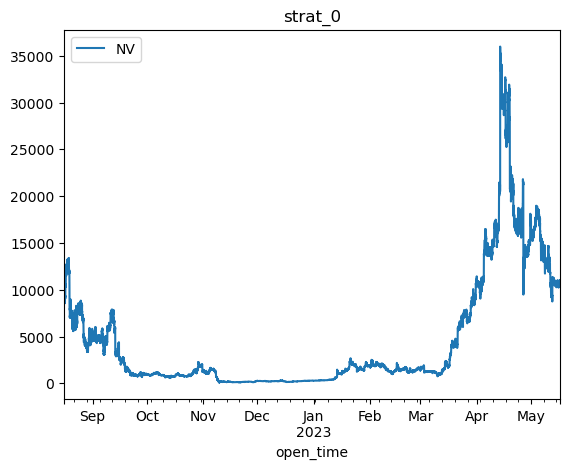

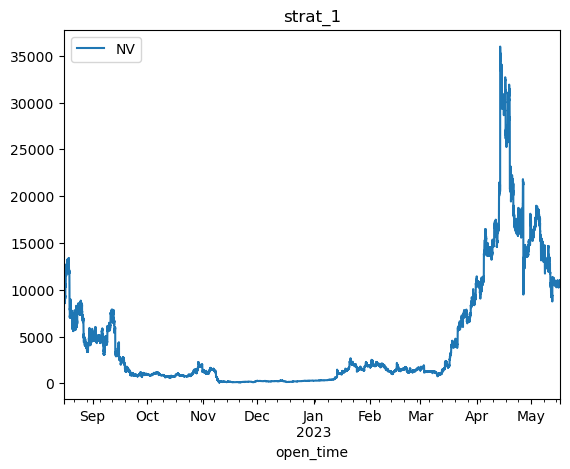

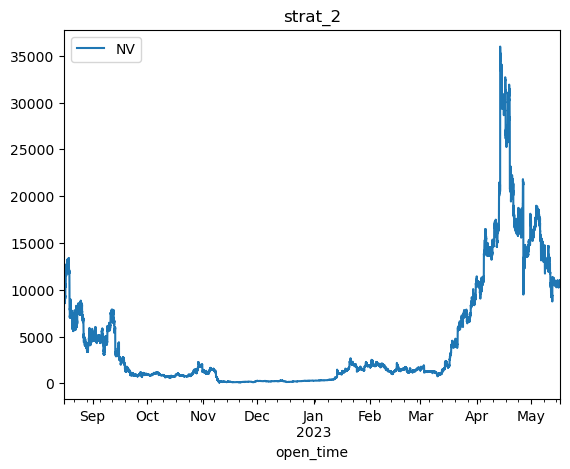

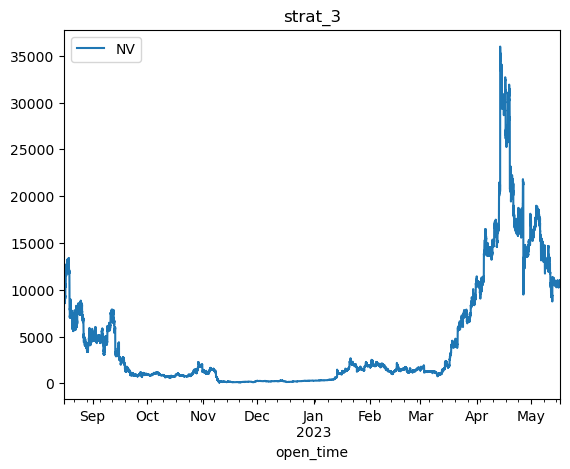

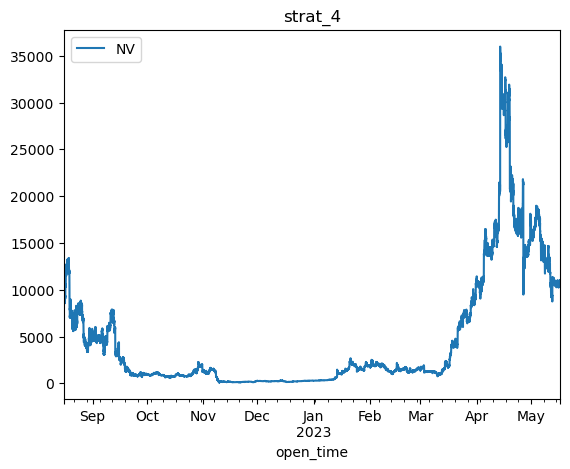

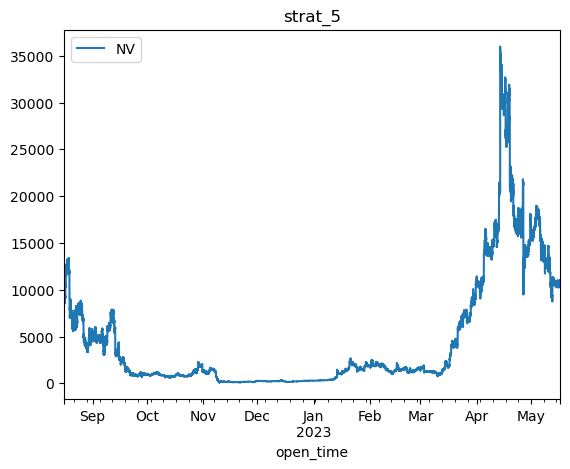

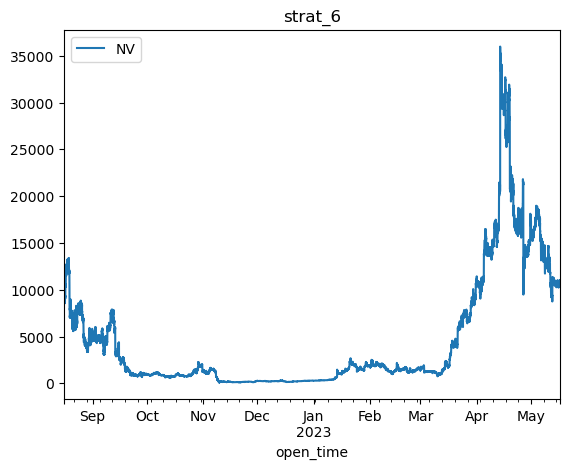

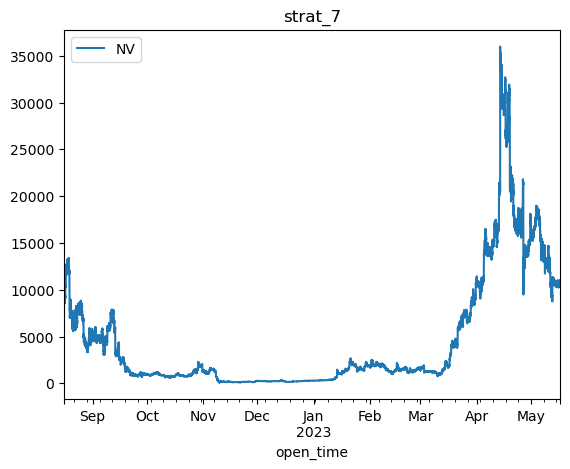

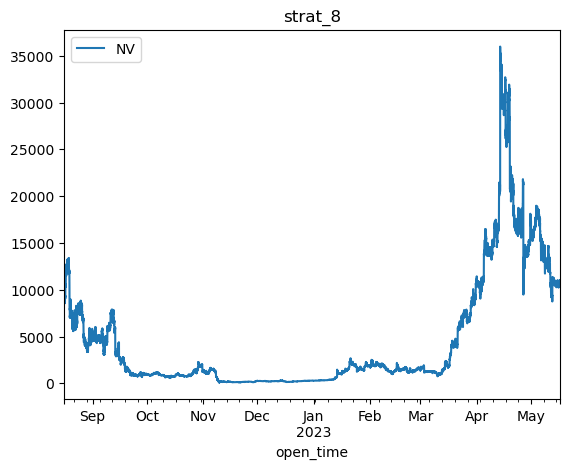

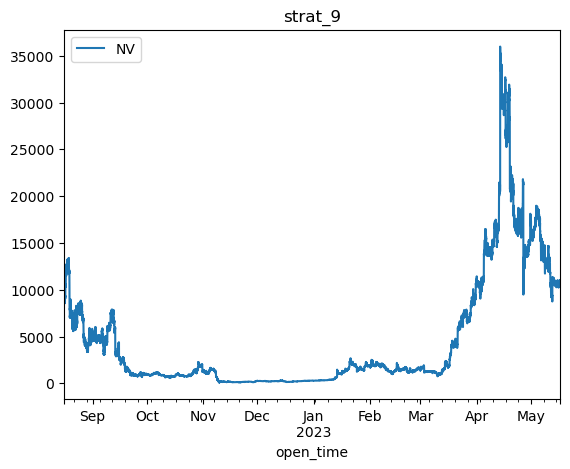

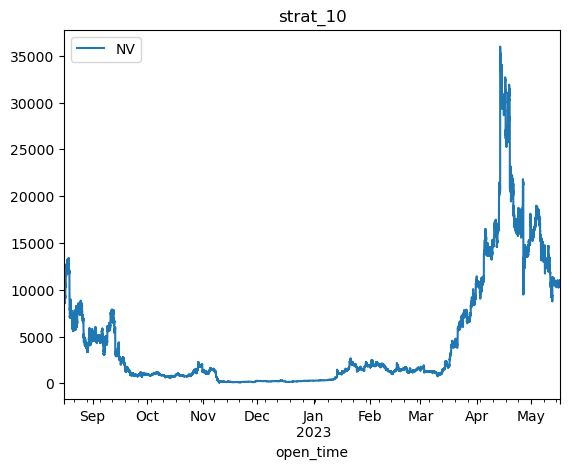

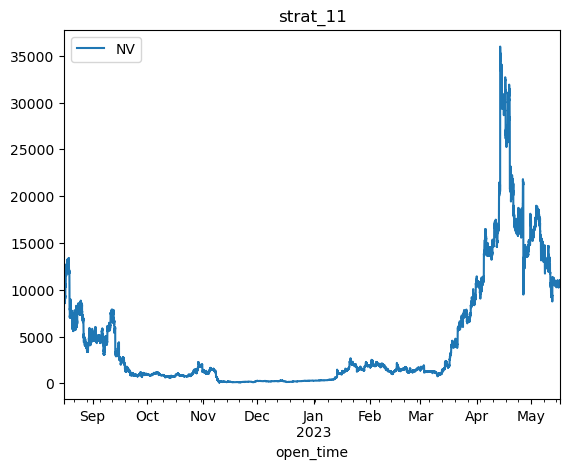

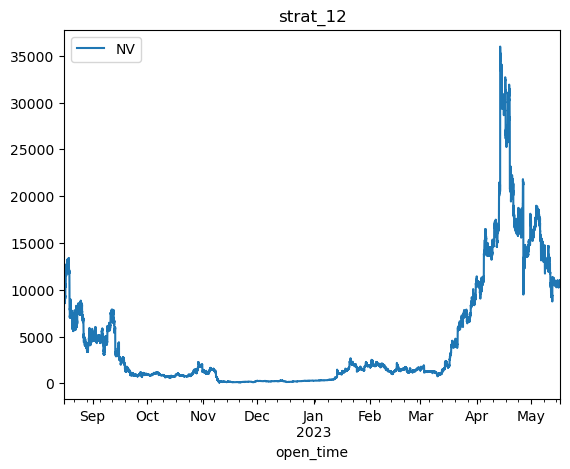

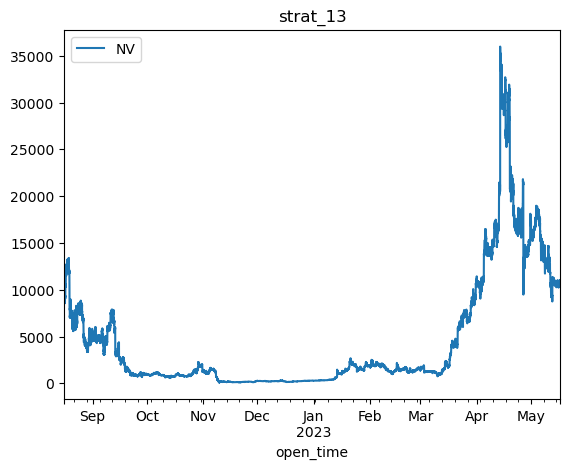

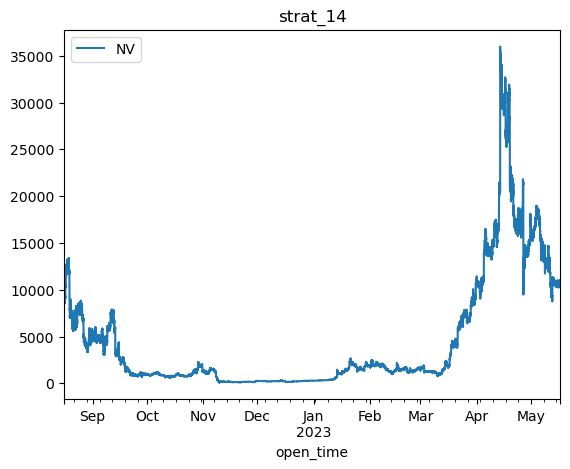

In [35]:
for key, value in result.items():
    value['NV'] = value['NV']
    ax = value.plot(x = 'open_time', y = 'NV', title = key)
    plt.show()

## Run back test for single strategy for high confidence predictions

In [34]:
df = pd.read_feather('../data/back_test_output_valid.feather')
df_btc = df.loc[df['token'] == 0].reset_index(drop = True)
df_btc

,open_time,label,target_15m,token,close,open,prob_0,prob_1,prob_2,pred_label
0,2022-08-16 07:12:00,0,0.000471,0,23989.6,23985.7,0.400532,0.298816,0.300652,0
1,2022-08-16 07:13:00,0,-0.000104,0,23981.6,23989.6,0.377836,0.332004,0.290160,0
2,2022-08-16 07:14:00,0,-0.000350,0,23991.8,23981.7,0.356332,0.332192,0.311475,0
3,2022-08-16 07:15:00,0,0.000100,0,23993.5,23991.8,0.318927,0.344530,0.336542,1
4,2022-08-16 07:16:00,0,0.000358,0,23993.4,23993.5,0.378381,0.295174,0.326444,0
...,...,...,...,...,...,...,...,...,...,...
394267,2023-05-17 02:19:00,0,-0.001573,0,27130.0,27129.9,0.453702,0.311832,0.234466,0
394268,2023-05-17 02:20:00,1,-0.002186,0,27132.7,27130.1,0.349693,0.385724,0.264583,1
394269,2023-05-17 02:21:00,1,-0.002075,0,27134.7,27132.6,0.275902,0.341119,0.382979,2
394270,2023-05-17 02:22:00,1,-0.002176,0,27134.3,27134.8,0.267229,0.344941,0.387830,2


In [118]:
def gen_pred_label(df_btc, threshold):
    pct_2 = (df_btc['prob_2'] > 0.4).sum() / df_btc.shape[0]
    pct_1 = (df_btc['prob_1'] > 0.4).sum() / df_btc.shape[0]
    print(f'{threshold} : Class 1 = {pct_1} ; Class 2 = {pct_2}')
    df_btc['pred_label'] = 0
    df_btc.loc['']

0.18174508968427888